# Я использовал предобработку данных из ДЗ прошлого курса. убрал мысли вслух и описания.

In [1]:
from sklearn.datasets import load_boston
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from pylab import rcParams

In [2]:
# Результаты регрессии сильно варьируются от запуска к запуску, поэтому результат надо усреднять. 
# У среднего хотя бы пара разрядов после запятой не пляшет
def run_many(features, target, num_runs=1000):
    
    result = 0
    max_score = -100
    min_score = 1
    
    for i in range(num_runs):
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)
        model = LinearRegression()
        model.fit(X_train, y_train)
        cur_score = model.score(X_test, y_test)
        result += cur_score
        if cur_score > max_score:
            max_score = cur_score
        if cur_score < min_score:
            min_score = cur_score
            
    result = result / num_runs
        
    return result, max_score, min_score

In [3]:
data = pd.read_csv(load_boston()['filename'], skiprows=1)

In [4]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [5]:
# Let's start from simple thing - LSTAT is almost the same as MEDV :)
# X_train, X_test, y_train, y_test = train_test_split(np.array(data['LSTAT']).reshape(-1,1), data['MEDV'], test_size=0.3)

# model = LinearRegression()
# model.fit(X_train, y_train)

run_many(np.array(data['LSTAT']).reshape(-1,1), data['MEDV'])

(0.5329206519007724, 0.6476001987872455, 0.37247737700539957)

Первую оценку - 0.534 получили без какого-либо анализа. Минимальная оценка - 0.3, максимальная - 0.64. Пробуем улучшить. 

Цена дома коррелирует со следующими параметрами (corr>0.5):
 - LSTAT: -0.85
 - RM: 0.63
 - INDUS: -0.58
 - TAX, PTRATIO, NOX, CRIM: -0.56
 - AGE: -0.55
    
При этом, NOX & CRIM обладают вымоким коэффициентом корреляции 0.82, поэтому в модель нужно ставить только один из признаков. Слегка странно видеть корреляцию между преступностью и экологией, но при здравом размышлении - логично :) Бедные районы находятся ближе к большим дорогам и фабрикам

Зависимость от RM похожа на линейную. Зависимость от LSTAT похожа на корень (не обязательно квадратный... проверим позже)

В колонке цен есть много значений 50 - очень похоже на ограничение сверху. Несмотря на то, что в оригинальном наборе данных про это не сказано ни слова, многие исследователи считают, что эти значения надо удалять

In [6]:
print(f'MEDV == 50 count: {len(data[data["MEDV"]==50])}')
print(f'40 <= MEDV < 50 count: {len(data[(data["MEDV"]<50) & (data["MEDV"]>=40)])}')

MEDV == 50 count: 16
40 <= MEDV < 50 count: 15


Значений 50 больше, чем в диапазоне 40-50. удаляем

In [7]:
data = data.drop(data[data['MEDV']==50].index)

Еще один метод определения важных параметров.

In [8]:
#Automatic feature selection
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

X = data.iloc[:,0:13]  #independent columns
y = np.array(data.iloc[:,-1])    #target column i.e price range

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=13)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(13,'Score'))  #print 10 best features



      Specs       Score
12    LSTAT  666.627892
5        RM  435.309814
2     INDUS  274.507475
9       TAX  237.855059
4       NOX  185.148836
10  PTRATIO  179.568192
6       AGE  156.620474
8       RAD  143.190234
0      CRIM  123.991786
1        ZN   95.527784
7       DIS   76.829959
11        B   74.972403
3      CHAS    2.745998


В итоговой модели я постепенно увеличивал кол-во параметров, добавляя их по старшинству из этого списка. NOX сильно коррелирует с INDUS, добавление его в модель не улучшит результат

In [9]:
#After several tries
data['LSTAT_sqrt'] = 1/(data['LSTAT']**(1/3))

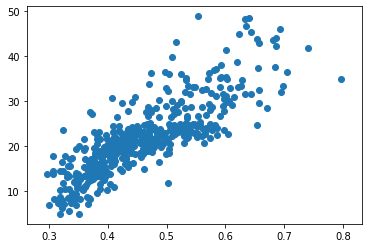

In [10]:
plt.scatter(data['LSTAT_sqrt'], data['MEDV'], marker='o')
plt.show()

In [11]:
# result = 0
# for i in range(1000):
#     X_train, X_test, y_train, y_test = train_test_split(np.array(data['LSTAT_sqrt']).reshape(-1,1), data['MEDV'], test_size=0.3)
#     model = LinearRegression()
#     model.fit(X_train, y_train)
#     result += model.score(X_test, y_test)

run_many(np.array(data['LSTAT_sqrt']).reshape(-1,1), data['MEDV'])

(0.6695994079201247, 0.7773040846743832, 0.5291875025252628)

Использование преобразования позволило увеличить оценку примерно на 0.13

Попробуем построить модель на основе двух свойств - $\frac{1}{\sqrt[3]{LSTAT}}$ & RM

In [12]:
# result = 0
# for i in range(1000):
#     X_train, X_test, y_train, y_test = train_test_split(np.array(data[['LSTAT_sqrt', 'RM']]), data['MEDV'], test_size=0.3)
#     model = LinearRegression()
#     model.fit(X_train, y_train)
#     result += model.score(X_test, y_test)
#     
# result

run_many(data[['LSTAT_sqrt', 'RM']], data['MEDV'])

(0.7024243575037071, 0.7931370495929798, 0.5211889783789713)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(np.array(data[['LSTAT_sqrt', 'RM']]), data['MEDV'], test_size=0.3)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("R2: \t", r2_score(y_test, y_pred))
print("RMSE: \t", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE: \t", mean_absolute_error(y_test, y_pred))

R2: 	 0.7411039648118618
RMSE: 	 3.9976586563745293
MAE: 	 3.109475515090638


0.7 - лучший результат, которого я достиг при использовании двух переменных. Ошибка предсказания цены составляет примерно 15-20 процентов от среднего значения. Не знаю, насколько это хорошо, но лучше чем в лекциях про Лос-Анжелес))

Ниже - лучший результат, который я получил, играясь с различными комбинациями столбцов. 0.77 - весьма неплохо, ИМХО :)

In [14]:
run_many(data[['LSTAT_sqrt', 'RM', 'INDUS', 'TAX', 'PTRATIO', 'CRIM', 'RAD', 'B']], data['MEDV'])

(0.773165941875828, 0.8469964520292825, 0.6171578691031026)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(np.array(
    data[['LSTAT_sqrt', 'RM', 'INDUS', 'TAX', 'PTRATIO', 'CRIM', 'RAD', 'B']]), data['MEDV'], test_size=0.3)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("R2: \t", r2_score(y_test, y_pred))
print("RMSE: \t", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE: \t", mean_absolute_error(y_test, y_pred))

R2: 	 0.7964132432241893
RMSE: 	 3.652733361597571
MAE: 	 2.7891683765297968


Ошибка стала меньше

Преобразования, подобного тому, что я сделал для LSTAT, я не смог подобрать... Все же время на учебную задачу должно быть в разумных пределах :)

# Новая работа начинается с этого места

In [16]:
def print_scores(y_real, y_pred):
    print("R2: \t", r2_score(y_real, y_pred))
    print("RMSE: \t", np.sqrt(mean_squared_error(y_real, y_pred)))
    print("MAE: \t", mean_absolute_error(y_real, y_pred))

In [17]:
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [18]:
X = data[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
          'PTRATIO', 'LSTAT_sqrt']]
y = data['MEDV']

In [19]:
# Немного преобразуем данные - сделаем их ближе к нормальному распределению
X = np.log1p(X)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [32]:
model = CatBoostRegressor(verbose=0)


In [33]:
model.fit(X_train, y_train)
preds = model.predict(X_test)
print_scores(y_test, preds)

R2: 	 0.8762653416433437
RMSE: 	 2.504730814032835
MAE: 	 1.8544750922521116


### Ниже результаты для разных моделей без подбора параметров. Видно, что бустинги существенно лучше регрессий. Будем работать только с бустингами, поэтому данные можно не нормализовывать

model = XGBRegressor(objective='reg:squarederror')
R2: 	 0.8581606174237356
RMSE: 	 2.6817222353260854
MAE: 	 1.9989641980427066

model = LGBMRegressor()
R2: 	 0.8797554690258083
RMSE: 	 2.469153236404405
MAE: 	 1.8475251088977604


model = LassoCV(cv=10, normalize=True)
R2: 	 0.7770551830609225
RMSE: 	 3.3621266336171165
MAE: 	 2.669845844584301

model = ElasticNetCV(cv=10, normalize=True)
R2: 	 0.7689105669692721
RMSE: 	 3.4229883450107645
MAE: 	 2.7236992011899224

model = LassoLarsCV(cv=10, normalize=True)
R2: 	 0.7770349479917484
RMSE: 	 3.3622792079677923
MAE: 	 2.6701010206887843

model = AdaBoostRegressor(loss='exponential')
R2: 	 0.8403101259385909
RMSE: 	 2.8454703597014324
MAE: 	 2.2328702190833867

model = ExtraTreesRegressor()
R2: 	 0.8897846531269153
RMSE: 	 2.3639398008650345
MAE: 	 1.7596747967479676

model = GradientBoostingRegressor(loss='ls')
R2: 	 0.8724626374937836
RMSE: 	 2.5429281685842247
MAE: 	 1.8716998016794788

model = CatBoostRegressor(verbose=0)
R2: 	 0.8762482470733898
RMSE: 	 2.504903828683421
MAE: 	 1.854637729167035

## для подбора параметров возьмем LightGBM, ExtraTrees, GradientBoostingRegressor, CatBoostRegressor

In [22]:
from sklearn.model_selection import GridSearchCV

## LightGBM tuning

In [80]:
cost_func = ['regression', 'regression_l1', 'huber', 'fair', 'poisson', 'quantile', 'mape', 'gamma', 'tweedie']
iters = [10, 30, 100, 300]
learning_r = [0.01, 0.03, 0.1, 0.3, 1]
min_leaf = [10, 20, 30, 40, 50, 80, 100]
bagging = [0.25, 0.5, 0.75, 1]

In [81]:
param_grid = dict(objective=cost_func, n_iter=iters, learning_rate=learning_r, min_data_in_leaf=min_leaf, bagging_fraction=bagging)

In [82]:
model = LGBMRegressor(n_jobs=-1)

In [83]:
grid = GridSearchCV(model, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

In [84]:
# grid.fit(X_train, y_train)

Fitting 10 folds for each of 5040 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1238 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 2884 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 5384 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 8295 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 12181 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 17228 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 22751 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 29801 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 36352 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 44213 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed: 14.0min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change f

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambd...
             param_grid={'bagging_fraction': [0.25, 0.5, 0.75, 1],
                         'learning_rate': [0.01, 0.03, 0.1, 0.3, 1],
                         'min_data_in_leaf': [10, 20, 30, 40, 50, 80, 100],
                         'n_iter': [10, 30, 100, 300],
                         'objective': ['regression', 'regression_l1', 'huber',
           

In [85]:
grid.best_estimator_
# LGBMRegressor(bagging_fraction=0.25, boosting_type='gbdt', class_weight=None,
#               colsample_bytree=1.0, importance_type='split', learning_rate=0.03,
#               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
#               min_data_in_leaf=10, min_split_gain=0.0, n_estimators=100,
#               n_iter=300, n_jobs=-1, num_leaves=31, objective='regression_l1',
#               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
#               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(bagging_fraction=0.25, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, importance_type='split', learning_rate=0.03,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=10, min_split_gain=0.0, n_estimators=100,
              n_iter=300, n_jobs=-1, num_leaves=31, objective='regression_l1',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [86]:
LGBM_model = LGBMRegressor(bagging_fraction=0.25, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, importance_type='split', learning_rate=0.03,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=10, min_split_gain=0.0, n_estimators=100,
              n_iter=300, n_jobs=-1, num_leaves=31, objective='regression_l1',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [90]:
LGBM_model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMRegressor(bagging_fraction=0.25, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, importance_type='split', learning_rate=0.03,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=10, min_split_gain=0.0, n_estimators=100,
              n_iter=300, n_jobs=-1, num_leaves=31, objective='regression_l1',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [91]:
preds = LGBM_model.predict(X_test)

In [92]:
print_scores(y_test, preds)

R2: 	 0.8569488014656543
RMSE: 	 2.693153623783459
MAE: 	 2.0725595588510006


## ExtraTree Tuning

In [48]:
n_est = [10, 30, 100, 300, 500, 1000]
depth = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]


In [49]:
param_grid = dict(n_estimators=n_est, max_depth=depth)
param_grid

{'n_estimators': [10, 30, 100, 300, 500, 1000],
 'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}

In [50]:
model = ExtraTreesRegressor()

In [51]:
grid = GridSearchCV(model, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

In [52]:
grid.fit(X_train, y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 327 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 577 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.7min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse',
                                           max_depth=None, max_features='auto',
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators='warn', n_jobs=None,
                                           oob_score=False, random_state=None,
                                           verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'n_estimators': [10, 30

In [53]:
grid.best_estimator_

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=15,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)

In [54]:
preds = grid.best_estimator_.predict(X_test)

In [55]:
print_scores(y_test, preds)

R2: 	 0.8971198139608294
RMSE: 	 2.2839218918632356
MAE: 	 1.649597766298583


In [56]:
ET_model = grid.best_estimator_

In [57]:
from sklearn.model_selection import cross_val_score

In [58]:
cross_val_score(ET_model, X_train, y_train, cv=10)

array([0.88757759, 0.83102697, 0.77766217, 0.89410985, 0.89160999,
       0.76335407, 0.91700927, 0.92000936, 0.90175009, 0.90397184])

In [35]:
# Результаты регрессии сильно варьируются от запуска к запуску, поэтому результат надо усреднять. 
# У среднего хотя бы пара разрядов после запятой не пляшет
# Model added
def run_many_model(rm, features, target, num_runs=1000):
    
    result = 0
    max_score = -100
    min_score = 1
    
    for i in range(num_runs):
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)
        model = rm
        model.fit(X_train, y_train)
        cur_score = model.score(X_test, y_test)
        result += cur_score
        if cur_score > max_score:
            max_score = cur_score
        if cur_score < min_score:
            min_score = cur_score
        if i%100 == 0:
            print('Current run:', i)
            
    result = result / num_runs
        
    return result, max_score, min_score

In [59]:
# run_many_model(ET_model, X_train, y_train)

## Gradient Boost tuning

In [37]:
# will use params from previous model
param_grid

{'n_estimators': [10, 30, 100, 300, 500, 1000],
 'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}

In [38]:
model = GradientBoostingRegressor(loss='ls')

In [39]:
grid = GridSearchCV(model, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

In [40]:
grid.fit(X_train, y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 580 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   46.1s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
               

In [41]:
grid.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=300,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [42]:
GB_model = grid.best_estimator_

In [43]:
preds = GB_model.predict(X_test)

In [44]:
print_scores(y_test, preds)

R2: 	 0.8749882112187877
RMSE: 	 2.517623951641858
MAE: 	 1.8512040240573129


# CatBoost Tuning

In [70]:
m_depth = [1, 3, 5, 7, 9, 11, 13, 15]
param_grid = dict(iterations=iters, depth=m_depth)
param_grid

{'iterations': [10, 30, 100, 300], 'depth': [1, 3, 5, 7, 9, 11, 13, 15]}

In [71]:
model = CatBoostRegressor(verbose=0)

In [72]:
grid = GridSearchCV(model, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

In [73]:
grid.fit(X_train, y_train)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 83.5min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x000000000E760BA8>,
             iid='warn', n_jobs=-1,
             param_grid={'depth': [1, 3, 5, 7, 9, 11, 13, 15],
                         'iterations': [10, 30, 100, 300]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

In [75]:
CB_model = grid.best_estimator_

In [79]:
grid.best_params_


{'depth': 5, 'iterations': 300}

In [93]:
CB_model.fit(X_train, y_train)

In [94]:
preds = CB_model.predict(X_test)

In [95]:
print_scores(y_test, preds)

R2: 	 0.8724670071991127
RMSE: 	 2.5428846051070906
MAE: 	 1.9236712052018066


# Scores once more:

In [98]:
models = [LGBM_model, ET_model, GB_model, CB_model]

In [103]:
total_preds = [0]*len(y_test)
for cur in models:
    preds = cur.predict(X_test)
    total_preds += preds
    print(cur)
    print_scores(y_test, preds)
    print('\n\n')
    
total_preds = total_preds/len(models)
print('Cumulative score:')
print_scores(y_test, total_preds)

LGBMRegressor(bagging_fraction=0.25, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, importance_type='split', learning_rate=0.03,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=10, min_split_gain=0.0, n_estimators=100,
              n_iter=300, n_jobs=-1, num_leaves=31, objective='regression_l1',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
R2: 	 0.8569488014656543
RMSE: 	 2.693153623783459
MAE: 	 2.0725595588510006



ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=15,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
                    oob_score=False, rand

Комбинирование решений не привело к улучшению оценок, тем не менее на случайных подвыборках средние результаты оказываются более стабильными. 